# Markov chain Monte Carlo

The main technical challenge in using Bayesian models resides in calculating the model's joint posterior distribution. 

Recall that we are interested in combining the information from our data, via the **likelihood** $Pr(y|\theta)$, and prior information, via the **prior distribution** $Pr(\theta)$, to produce a joint posterior distribution for the model of interest:

$$Pr(\theta | y) \propto Pr(y|\theta) Pr(\theta)$$

However, to guarantee that the posterior is itself a proper probability density (and not just proportional to one), it has to be normalized by dividing by the **marginal likelihood**:

$$Pr(\theta | y) = \frac{Pr(y|\theta) Pr(\theta)}{Pr(y)}$$

The marginal likelihood is the numerator, integrated over the parameters $\theta$:

$$Pr(\theta | y) = \frac{Pr(y|\theta) Pr(\theta)}{\int_{\theta} Pr(y|\theta) Pr(\theta) d\theta}$$

which, except for very simple (one- or two-parameter) models cannot be calculated analytically.

The two alternative strategies to obtaining posteriors for moderate to large models involve either analytic **approximations** or stochastic **sampling**. Approximations are usually valid conditional on assumptions regarding the true posterior distribution, which are typically impossible to validate. Direct sampling strategies rely on our ability to sample from the posterior distribution, and this is frequently not possible. Indirect sampling methods, such as rejection sampling, can be plagued with sampling efficiency issues.

The sampling approaches we have introduced so far have each attempted to obtain *independent* samples from the posterior distribution. It turns out, however, that it is possible to generate samples from the posterior distribution using a *dependent* sampling algorithm, and despite the dependence of the samples, one may extract valid inference from them. A class of algorithms called **Markov chain Monte Carlo** yields a Markovian sample (explained below) which, provided that certain conditions are satisfied, is guaranteed to be indistinguishable from a sample drawn from the true posterior itself.

## Markov Chains

A Markov chain is a special type of **stochastic process**. The standard definition of a stochastic process is an ordered collection of random variables:

$$\{X_t: t \in T\}$$

where $t$ is frequently (but not necessarily) a time index. If we think of $X_t$ as a state $X$ at time $t$, and invoke the following dependence condition on each state:

$$Pr(X_{t+1}=x_{t+1} | X_t=x_t, X_{t-1}=x_{t-1},\ldots,X_0=x_0) = Pr(X_{t+1}=x_{t+1} | X_t=x_t)$$

then the stochastic process is known as a **Markov chain**. This conditioning specifies that the future depends on the current state, but not past states. Thus, the Markov chain wanders about the state space, remembering only where it has just been in the last time step. The collection of transition probabilities is sometimes called a **transition matrix** when dealing with discrete states, or more generally, a
**kernel**.

In the context of Markov chain Monte Carlo, it is useful to think of the Markovian property as “mild non-independence”. MCMC allows us to indirectly generate independent samples from a particular posterior distribution.


## Why MCMC Works: Reversible Markov Chains

Markov chain Monte Carlo simulates a Markov chain for which some function of interest
(*e.g.* the joint distribution of the parameters of some model) is the unique, invariant limiting distribution. An invariant distribution with respect to some Markov chain with transition kernel $Pr(y \mid x)$ implies that:

$$\int_x Pr(y \mid x) \pi(x) dx = \pi(y).$$

Invariance is guaranteed for any **reversible** Markov chain. Consider a Markov chain in reverse sequence:
$\{\theta^{(n)},\theta^{(n-1)},...,\theta^{(0)}\}$. This sequence is still Markovian, because:

$$Pr(\theta^{(k)}=y \mid \theta^{(k+1)}=x,\theta^{(k+2)}=x_1,\ldots ) = Pr(\theta^{(k)}=y \mid \theta^{(k+1)})=x$$

Forward and reverse transition probabilities may be related through Bayes theorem:

$$Pr(\theta^{(k)}=y \mid \theta^{(k+1)}=x) = \frac{Pr(\theta^{(k+1)}=x \mid \theta^{(k)}=y) \pi^{(k)}(y)}{\pi^{(k+1)}(x)}$$

Though not homogeneous in general, $\pi$ becomes homogeneous if:

-   $n \rightarrow \infty$

-   $\pi^{(i)}=\pi$ for some $i < k$

If this chain is homogeneous it is called reversible, because it satisfies the **detailed balance equation**:

$$\pi(x)Pr(y \mid x) = \pi(y) Pr(x \mid y)$$

Reversibility is important because it has the effect of balancing movement through the entire state space. When a Markov chain is reversible, $\pi$ is the unique, invariant, stationary distribution of that chain. Hence, if $\pi$ is of interest, we need only find the reversible Markov chain for which $\pi$ is the limiting distribution.
This is what MCMC does!

## The Metropolis-Hastings Algorithm

One of the simplest and most flexible algorithms for generating reversible Markov chains is the Metropolis-Hastings algorithm. Since we cannot sample directly from the (unknown) posterior distribution, this algorithm employs an **auxilliary distribution** that is easy to sample from. These samples generate candidate state transitions, which are accepted or rejected probabilistically.

![](images/Metropolis.png)

Let us first consider a simple Metropolis-Hastings algorithm for a single parameter, $\theta$. We will use a well-known statistical distribution to produce candidate variables $q_t(\theta^{\prime} | \theta)$. Each generated value, $\theta^{\prime}$, is a *possible* next value for
$\theta$ at step $t+1$. 

Whether or not $\theta^{\prime}$ is accepted depends on the relative probability of the new value versus the current value, weighted by the probabilities of the two values under the proposal distribution: 

$$a(\theta^{\prime},\theta) = \frac{q_t(\theta^{\prime} | \theta) \pi(\theta^{\prime})}{q_t(\theta | \theta^{\prime}) \pi(\theta)}$$

This is the **acceptance ratio**, and is used as a threshold value for a uniform random draw that determines acceptance:

$$
\theta^{(t+1)} = 
\begin{cases}
\theta^{\prime}  & \text{with prob. } p = \min(a(\theta^{\prime},\theta^{(t)}),1)\cr
\theta^{(t)}  & \text{with prob } 1 - p
\end{cases}
$$

This transition kernel implies that movement is not guaranteed at every step. It only occurs if the suggested transition is likely based on the acceptance ratio.

A single iteration of the Metropolis-Hastings algorithm proceeds as follows:

1.  Sample $\theta^{\prime}$ from $q(\theta^{\prime} | \theta^{(t)})$.

2.  Generate a Uniform[0,1] random variate $u$.

3.  If $a(\theta^{\prime},\theta) > u$ then
    $\theta^{(t+1)} = \theta^{\prime}$, otherwise
    $\theta^{(t+1)} = \theta^{(t)}$.
    

### Random-walk Metropolis-Hastings

We still have not talked about how to choose the proposal $q$. In principle, it can be just about anything, but some choices are wiser than others. A practical implementation of the Metropolis-Hastings algorithm makes use of a **random-walk** proposal.

A random walk is a Markov chain that evolves according to:

$$\begin{aligned}
\theta^{(t+1)} &= \theta^{(t)} + \epsilon_t \\
\epsilon_t &\sim f(\phi)
\end{aligned}$$

As applied to the MCMC sampling, the random walk is used as a proposal distribution, whereby dependent proposals are generated according to:

$$q(\theta^{\prime} | \theta^{(t)}) = f(\theta^{\prime} - \theta^{(t)}) = \theta^{(t)} + \epsilon_t$$

Generally, the density generating $\epsilon_t$ is **symmetric** about zero,
resulting in a symmetric chain. Chain symmetry implies that
$q(\theta^{\prime} | \theta^{(t)}) = q(\theta^{(t)} | \theta^{\prime})$,
which reduces the Metropolis-Hastings acceptance ratio to:

$$a(\theta^{\prime},\theta) = \frac{\pi(\theta^{\prime})}{\pi(\theta)}$$

The choice of the random walk distribution for $\epsilon_t$ is frequently a normal or Student’s $t$ density, but it may be any distribution that generates an irreducible proposal chain.

An important consideration is the specification of the **scale parameter** for the random walk error distribution. Large values produce random walk steps that are highly exploratory, but tend to produce proposal values in the tails of the target distribution, potentially resulting in very small acceptance rates. Conversely, small values tend to be accepted more frequently, since they tend to produce proposals close to the current parameter value, but may result in chains that mix very slowly.

Some simulation studies suggest optimal acceptance rates in the range of **20-50%**. It is often worthwhile to optimize the proposal variance by iteratively adjusting its value, according to observed acceptance rates early in the MCMC simulation .

## Example: Linear model estimation

This very simple dataset is a selection of real estate prices, with the associated age of each house. We wish to estimate a simple linear relationship between the two variables, using the Metropolis-Hastings algorithm.

$$\mu_i = \beta_0 + \beta_1 a_i$$

$$p_i \sim N(\mu_i, \tau)$$

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

age = np.array([13, 14, 14,12, 9, 15, 10, 14, 9, 14, 13, 12, 9, 10, 15, 11, 
                15, 11, 7, 13, 13, 10, 9, 6, 11, 15, 13, 10, 9, 9, 15, 14, 
                14, 10, 14, 11, 13, 14, 10])
price = np.array([2950, 2300, 3900, 2800, 5000, 2999, 3950, 2995, 4500, 2800, 
                  1990, 3500, 5100, 3900, 2900, 4950, 2000, 3400, 8999, 4000, 
                  2950, 3250, 3950, 4600, 4500, 1600, 3900, 4200, 6500, 3500, 
                  2999, 2600, 3250, 2500, 2400, 3990, 4600, 450,4700])/1000.

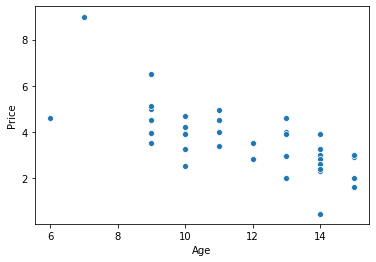

In [2]:
sns.scatterplot(age, price)
plt.xlabel('Age')
plt.ylabel('Price');

This function calculates the joint log-posterior, conditional on values for each paramter:

In [3]:
from scipy.stats import gamma, norm
dgamma = gamma.logpdf
dnorm = norm.logpdf

def calc_posterior(a, b, t, y=price, x=age):
    # Calculate joint posterior, given values for a, b and t

    # Priors on a,b
    logp = dnorm(a, 0, 10000) + dnorm(b, 0, 10000)
    # Prior on t
    logp += dgamma(t, 0.001, 0.001)
    # Calculate mu
    mu = a + b*x
    # Data likelihood
    logp += sum(dnorm(y, mu, t**-0.5))
    
    return logp

In [4]:
rnorm = np.random.normal
runif = np.random.rand
np.random.seed(42)

def metropolis(n_iterations, initial_values, prop_var=1):

    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    prop_sd = [prop_var]*n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(*trace[0])
    
    # Initialize acceptance counts
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%1000: print('Iteration %i' % i)
    
        # Grab current parameter values
        current_params = trace[i]
    
        for j in range(n_params):
    
            # Get current value for parameter j
            p = trace[i].copy()
    
            # Propose new value
            if j==2:
                # Ensure tau is positive
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
                
    return trace, accepted

Let's run the MH algorithm with a very small proposal variance:

In [5]:
n_iter = 5000
trace, acc = metropolis(n_iter, (1,0,1), 0.001)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000


We can see that the acceptance rate is way too high:

In [6]:
np.array(acc, float)/n_iter

array([0.9664, 0.9522, 0.9486])

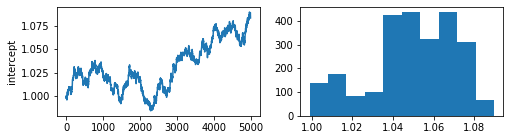

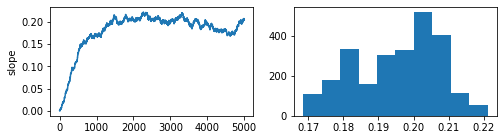

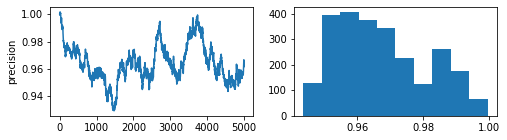

In [7]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(n_iter/2):])

Now, with a very large proposal variance:

In [8]:
trace_hivar, acc = metropolis(n_iter, (1,0,1), 20)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000


In [9]:
np.array(acc, float)/n_iter

array([0.0152, 0.0008, 0.0172])

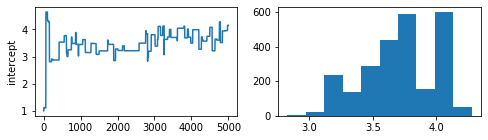

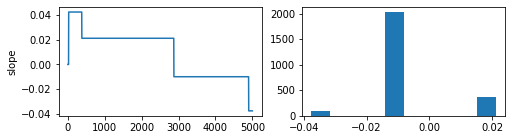

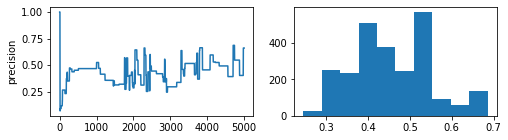

In [10]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace_hivar.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(n_iter/2):])

In order to avoid having to set the proposal variance by trial-and-error, we can add some tuning logic to the algorithm. 

## Auto-tuning Metropolis-Hastings

We can modify the Metropolis-Hastings algorithm above by adding logic to automatically change the proposal scale depending on the acceptance rate of the chain. 

In [11]:
def metropolis_tuned(n_iterations, initial_values, prop_var=1, 
                     tune_for=None, tune_interval=100):
     
    n_params = len(initial_values)
             
    # Initial proposal standard deviations
    prop_sd = [prop_var] * n_params
     
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
     
    # Set initial values
    trace[0] = initial_values
    # Initialize acceptance counts
    accepted = [0]*n_params
     
    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(*trace[0])
     
    if tune_for is None:
        tune_for = n_iterations/2
     
    for i in range(n_iterations):
     
        if not i%1000: print('Iteration %i' % i)
     
        # Grab current parameter values
        current_params = trace[i]
     
        for j in range(n_params):
     
            # Get current value for parameter j
            p = trace[i].copy()
     
            # Propose new value
            if j==2:
                # Ensure tau is positive
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])
             
            # Insert new value 
            p[j] = theta
     
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)
     
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
     
            # Sample a uniform random variate
            u = runif()
     
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
                 
            # Tune every 100 iterations
            if (not (i+1) % tune_interval) and (i < tune_for):
         
                # Calculate aceptance rate
                acceptance_rate = (1.*accepted[j])/tune_interval
                if acceptance_rate<0.2:
                    prop_sd[j] *= 0.9
                elif acceptance_rate>0.4:
                    prop_sd[j] *= 1.1
                accepted[j] = 0
                 
    return trace[tune_for:], accepted

In [12]:
trace_tuned, acc = metropolis_tuned(10000, (10,0,1), tune_for=5000,tune_interval=10)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


In [14]:
np.array(acc, float)/5000

array([0.3224, 0.221 , 0.2772])

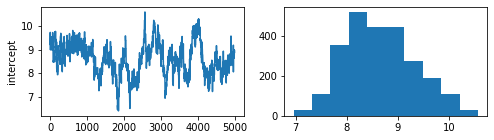

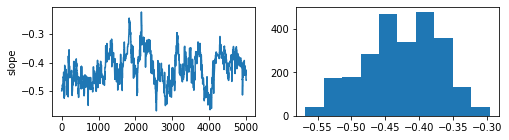

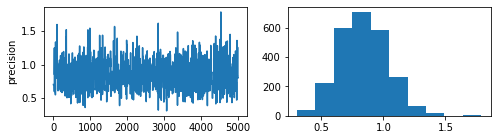

In [15]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace_tuned.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(len(samples)/2):])

A useful way to informally examine the fit of the model is to examine functions of the posterior distribution. For example, here are 50 random regression lines drawn from the posterior:

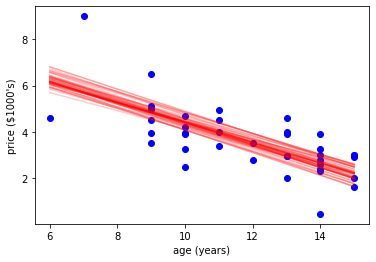

In [17]:
plt.plot(age, price, 'bo')
plt.xlabel('age (years)'); plt.ylabel('price ($1000\'s)')
xvals = np.linspace(age.min(), age.max())
for i in range(50):
    b0,b1,tau = trace_tuned[np.random.randint(0, 1000)]
    plt.plot(xvals, b0 + b1*xvals, 'r-', alpha=0.2)

# Hamiltonian Monte Carlo

While flexible and easy to implement, Metropolis-Hastings sampling is a random walk
sampler that might not be statistically efficient for many models. Specifically, for models of high dimension, random walk jumping algorithms do not perform well. It is not enough to simply guess at the next sample location; we need to make each iteration a useful draw from the posterior whenever we can, in order to have an efficient sampler for bigger models.

![from Hoffman and Gelman 2014](http://d.pr/i/RAA+)

(*image: Hoffman and Gelman, 2014*)

Since Bayesian inference is all about calculating expectations over posteriors, what we seek is an algorithm that samples from the area of the parameter space that contains most of the non-zero probability. This region is called the **typical set**.

### What's a Typical Set?

The typical set is where most of the probability lies in a particular volume associated with the distribution. As the dimension of a model increases, this set moves progressively further from the mode, and becomes more singular, as the result of concentration of measure.

The typical set is a product of both the density, which is highest at the mode, and volume (that we integrate over), which increasingly becomes larger away from the mode as dimensionality increases. In fact, at high dimensions, the region around the mode contributes almost nothing to the expectation. We need an algorithm that will find this narrow region and explore it efficiently.

![](images/typical_set_.png)

(image: Betancourt 2017)

In this context, and when sampling from continuous variables, Hamiltonian (or Hybrid) Monte
Carlo (HMC) can prove to be a powerful tool. It avoids
random walk behavior by simulating a physical system governed by
Hamiltonian dynamics, potentially avoiding tricky conditional
distributions in the process.

### Simulating Hamiltonian Dynamics

In HMC, model samples are obtained by simulating a physical system,
where particles move about a high-dimensional landscape, subject to
potential and kinetic energies. Adapting the notation from [Neal (1993)](http://www.cs.toronto.edu/~radford/review.abstract.html),
particles are characterized by a position vector or state
$s \in \mathcal{R}^D$ and velocity vector $\phi \in \mathcal{R}^D$. The
combined state of a particle is denoted as $\chi=(s,\phi)$. 

The joint **canonical distribution** of the position and velocity can be expressed as a product of the marginal position (which is of interest) and the conditional distribution of the velocity:

$$\pi(s, \phi) = \pi(\phi | s) \pi(s)$$

This joint probability can also be written in terms of an invariant **Hamiltonian function**:

$$\pi(s, \phi) \propto \exp(-H(s,\phi))$$

The Hamiltonian is then defined as the sum of potential energy $E(s)$ and kinetic energy
$K(\phi)$, as follows:

$$\mathcal{H}(s,\phi) = E(s) + K(\phi)
= E(s) + \frac{1}{2} \sum_i \phi_i^2$$

Instead of sampling $p(s)$ directly, HMC operates by sampling from the canonical distribution.

$$p(s,\phi) = \frac{1}{Z} \exp(-\mathcal{H}(s,\phi))=p(s)p(\phi)$$.

If we choose a momentum that is independent of position, marginalizing over $\phi$ is
trivial and recovers the original distribution of interest.

The Hamiltonian $\mathcal{H}$ is independent of the parameterization of the model, and therefore, captures the geometry of the phase space distribution, including typical set. 

**Hamiltonian Dynamics**

State $s$ and velocity $\phi$ are modified such that
$\mathcal{H}(s,\phi)$ remains constant throughout the simulation. The
differential equations are given by:

$$\begin{aligned}\frac{ds_i}{dt} &= \frac{\partial \mathcal{H}}{\partial \phi_i} = \phi_i \\
\frac{d\phi_i}{dt} &= - \frac{\partial \mathcal{H}}{\partial s_i}
= - \frac{\partial E}{\partial s_i}
\end{aligned}$$

As shown in [Neal (1993)](http://www.cs.toronto.edu/~radford/review.abstract.html), 
the above transformation preserves volume and is
reversible. The above dynamics can thus be used as transition operators
of a Markov chain and will leave $p(s,\phi)$ invariant. That chain by
itself is not ergodic however, since simulating the dynamics maintains a
fixed Hamiltonian $\mathcal{H}(s,\phi)$. HMC thus alternates Hamiltonian
dynamic steps, with Gibbs sampling of the velocity. Because $p(s)$ and
$p(\phi)$ are independent, sampling $\phi_{new} \sim p(\phi|s)$ is
trivial since $p(\phi|s)=p(\phi)$, where $p(\phi)$ is often taken to be
the univariate Gaussian.

![](images/skate_park.jpg)

**The Leap-Frog Algorithm**

In practice, we cannot simulate Hamiltonian dynamics exactly because of
the problem of time discretization. There are several ways one can do
this. To maintain invariance of the Markov chain however, care must be
taken to preserve the properties of *volume conservation* and *time
reversibility*. The **leap-frog algorithm** maintains these properties
and operates in 3 steps:

$$\begin{aligned}
\phi_i(t + \epsilon/2) &= \phi_i(t) - \frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t)) \\
s_i(t + \epsilon) &= s_i(t) + \epsilon \phi_i(t + \epsilon/2) \\
\phi_i(t + \epsilon) &= \phi_i(t + \epsilon/2) - \frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t + \epsilon)) 
\end{aligned}$$

We thus perform a half-step update of the velocity at time
$t+\epsilon/2$, which is then used to compute $s(t + \epsilon)$ and
$\phi(t + \epsilon)$.

**Accept / Reject**

In practice, using finite stepsizes $\epsilon$ will not preserve
$\mathcal{H}(s,\phi)$ exactly and will introduce bias in the simulation.
Also, rounding errors due to the use of floating point numbers means
that the above transformation will not be perfectly reversible.

HMC cancels these effects **exactly** by adding a Metropolis
accept/reject stage, after $n$ leapfrog steps. The new state
$\chi' = (s',\phi')$ is accepted with probability $p_{acc}(\chi,\chi')$,
defined as:

$$p_{acc}(\chi,\chi') = min \left( 1, \frac{\exp(-\mathcal{H}(s',\phi')}{\exp(-\mathcal{H}(s,\phi)} \right)$$

**HMC Algorithm**

We obtain a new HMC sample as follows:

1.  sample a new velocity from a univariate Gaussian distribution
2.  perform $n$ leapfrog steps to obtain the new state $\chi'$
3.  perform accept/reject move of $\chi'$

## Example: Normal mixture

HMC as implemented in PyMC3 is heavily automated. To provide some innsight into how the components of HMC work, let's look at a simpler implementation provided by [`minimc`](https://github.com/ColCarroll/minimc), a package created by Colin Carroll. This can be used to illustrate leapfrog integration and the paths taken for HMC sampling.

The example we will employ here is a mixture of three bivariate normal distribution, each with its own location and covariance. 

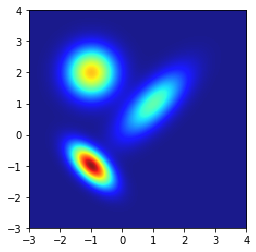

In [23]:
from autograd import grad
import autograd.numpy as np
from minimc import mixture, neg_log_mvnormal

# Plotting helper function
def neg_log_p_to_img(neg_log_p, extent=None, num=100):
    if extent is None:
        extent = (-3, 3, -3, 3)
    X, Y = np.meshgrid(np.linspace(*extent[:2], num), np.linspace(*extent[2:], num))
    Z = np.array([np.exp(-neg_log_p(j)) for j in np.array((X.ravel(), Y.ravel())).T]).reshape(X.shape)
    return Z, extent

np.random.seed(7)

mu1 = np.ones(2)
cov1 = 0.5 * np.array([[1., 0.7],
                       [0.7, 1.]])
mu2 = -mu1
cov2 = 0.2 * np.array([[1., -0.6],
                       [-0.6, 1.]])

mu3 = np.array([-1., 2.])
cov3 = 0.3 * np.eye(2)

neg_log_p = mixture([neg_log_mvnormal(mu1, cov1), 
                     neg_log_mvnormal(mu2, cov2), 
                     neg_log_mvnormal(mu3, cov3)], [0.3, 0.3, 0.4])

Z, extent = neg_log_p_to_img(neg_log_p, (-3, 4, -3, 4), num=200)

plt.imshow(Z, alpha=0.9, extent=extent, cmap='jet', origin='top')

Though simple, this would be very challenging for a Metropolis sampler, which would have a great deal of difficulty crossing the areas of low probabilities between the peaks. Most of the time, you would end up with an estimate of one of the three components, leaving the others entirely unexplored.

### Leapfrog Integration

We can explore the paths taken by HMC samplers by simulating from a leapfrog integrator, which varies by the amount of momentum and the size and number of steps taken.

In [27]:
from minimc.minimc_slow import leapfrog, hamiltonian_monte_carlo
from minimc import neg_log_mvnormal

dVdq = grad(neg_log_p)

steps = slice(None, None, 40)

positions, momentums = [], []
for _ in range(3):
    q, p = np.random.randn(2, 2)
    (t1, t2, q, p,s) = leapfrog(q, p, dVdq, 4 * np.pi, 0.01)
    positions.append(q)
    momentums.append(p)

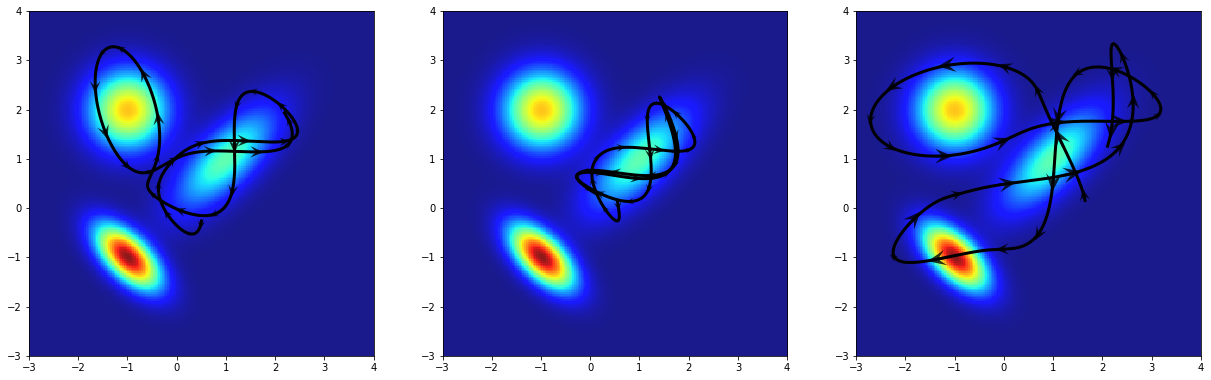

In [31]:
fig, axes = plt.subplots(ncols=len(positions), figsize=(7 * len(positions), 7))

steps = slice(None, None, 40)

Z, extent = neg_log_p_to_img(neg_log_p, (-3, 4, -3, 4), num=200)

for idx, (ax, q, p) in enumerate(zip(axes.ravel(), positions, momentums)):
    ax.imshow(Z, alpha=0.9, extent=extent, cmap='jet', origin='top')

    ax.quiver(q[steps, 0], q[steps, 1], p[steps, 0], p[steps, 1], headwidth=6, 
              scale=60, headlength=7, alpha=0.8, color='k')
    ax.plot(q[:, 0], q[:, 1], '-', lw=3, color='k')

## Hamiltonian Monte Carlo

Rolling leapfrog integration into HMC requires additional choices concerning path length (how far to leapfrog).

In [35]:
np.random.seed(111)
ss, pp, mm, pl = [], [], [], [1, 2, 4]
for path_len in pl:
    samples, positions, momentums, accepted,p_accepts = hamiltonian_monte_carlo(10, 
                                                                      neg_log_p, 
                                                                      np.random.randn(2), 
                                                                      path_len=path_len, 
                                                                      step_size=0.01)
    ss.append(samples)
    pp.append(positions)
    mm.append(momentums)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


IndexError: invalid index to scalar variable.

In [36]:
fig, axes = plt.subplots(ncols=len(ss), figsize=(7 * len(ss), 7))

Z, extent = neg_log_p_to_img(neg_log_p, (-3, 4, -3, 4), num=200)
steps = slice(None, None, 20)

for ax, samples, positions, momentums, path_len in zip(axes.ravel(), ss, pp, mm, pl):
    ax.imshow(Z, alpha=0.9, extent=extent, cmap='afmhot_r', origin='top')

    for q, p in zip(positions, momentums):
        ax.quiver(q[steps, 0], q[steps, 1], p[steps, 0], p[steps, 1], headwidth=6, 
                  scale=60, headlength=7, alpha=0.8)
        ax.plot(q[:, 0], q[:, 1], 'k-', lw=3)

    ax.plot(samples[:, 0], samples[:, 1], 'o', color='w', mfc='C1', ms=10)
    ax.set_title(f'Path length of {path_len}')


<Figure size 0x504 with 0 Axes>

---

## To Learn More

- **Neal, R. M. (2010)** [MCMC using Hamiltonian dynamics](http://www.mcmchandbook.net/HandbookChapter5.pdf), in the Handbook of Markov Chain Monte Carlo, S. Brooks, A. Gelman, G. L. Jones, and X.-L. Meng (editors), Chapman & Hall / CRC Press, pp. 113-162.
- **Michael Betancourt's "[A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434)"** A thorough, readable reference that is the main source here
- **Hoffman, M. D., and A. Gelman. (2014)**. “The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo.” Journal of Machine Learning Research: JMLR 15 (1): 1593–1623.
- **[Hamiltonian Monte Carlo from Scratch](https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/)**, by Colin Carroll, from which the HMC code was stolen.